## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=5000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=4.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.33, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.33, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G3", basePower=1.33, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-CostFrequency-C6-5k-CostProfiles_2'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=4.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.33, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.33, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G3', basePower=1.33, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=2.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=5000, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-CostFrequency-C6-5k-CostProfiles_

Train Agents

In [18]:
def rewardFn(deltaFreq, totalCost):
    scaledCost = totalCost/(1000.0) # Scale down cost to levels near the ones found in output differential (e.g. 10 */ 10)
    costComponent = 2**(-1*(scaledCost**2)/50)
    freqComponent = 4*2**(-1*(deltaFreq**2)*8)+4*2**(-1*(deltaFreq**2)/2) + 2**(-1*(deltaFreq**2)/100)
    earnedReward = costComponent*freqComponent
    
#     print(f'Scaled_Cost:{scaledCost} - deltaFreq:{deltaFreq} - costComponent:{costComponent} - freqComponent:{freqComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'freq': freqComponent, 'total': earnedReward}

In [19]:
from learning.cost_frequency import ModelAdapterCostFrequency as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0917 20:48:15.676361 140004982458112 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0917 20:48:15.678186 140004982458112 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0917 20:48:15.705606 140004982458112 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 3Gens-CostFrequency-C6-5k-CostProfiles_2 - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-CostFrequency-C6-5k-CostProfiles_2/model
CPU times: user 21h 21min 22s, sys: 2h 54min 28s, total: 1d 15min 51s
Wall time: 10h 4min 26s


In [20]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:3.8710749336461765 - deltaFreq:0.5971751336209508 - costComponent:0.8124188264380632 - freqComponent:5.086137262533569 - reward:4.132073665930426
Scaled_Cost:3.6203680130796334 - deltaFreq:-0.7481601203547044 - costComponent:0.8338493764036347 - freqComponent:4.470284001567055 - reward:3.7275435270538337
Scaled_Cost:3.3712965651804745 - deltaFreq:0.34172317767449556 - costComponent:0.8542245046132285 - freqComponent:6.93387229717516 - reward:5.92308362810584
Scaled_Cost:3.1238611173300734 - deltaFreq:-0.32975309924530194 - costComponent:0.8734698642351715 - freqComponent:7.040053857203906 - reward:6.149274886860192
Scaled_Cost:3.037230240699846 - deltaFreq:-0.22295122164415915 - costComponent:0.8799568276830458 - freqComponent:7.967695053964048 - reward:7.0112276636320985
Scaled_Cost:2.7924987929300302 - deltaFreq:0.0592366472535204 - costComponent:0.8975343192663631 - freqComponent:8.918034813199124 - reward:8.004242305258403
Scaled_Cost:2.708571916380389 - deltaFreq:-0.49

Scaled_Cost:3.040750909691599 - deltaFreq:-0.12211774201647785 - costComponent:0.8796958298198779 - freqComponent:8.66180850546588 - reward:7.619756820956684
Scaled_Cost:3.1227410832634455 - deltaFreq:-0.11861014666176573 - costComponent:0.873554586884148 - freqComponent:8.680261883013518 - reward:7.58268258326209
Scaled_Cost:3.2050142927878893 - deltaFreq:-0.0981675795041852 - costComponent:0.8672727393359676 - freqComponent:8.778454136098903 - reward:7.613313965749651
Scaled_Cost:3.122744644710104 - deltaFreq:-0.16555623129647046 - costComponent:0.8735543175210474 - freqComponent:8.397990885638887 - reward:7.336101196652254
Scaled_Cost:3.040758532397891 - deltaFreq:-0.11260726225962969 - costComponent:0.8796952644815603 - freqComponent:8.710772406741704 - reward:7.662825236187321
Scaled_Cost:2.959061776054749 - deltaFreq:-0.17205257749649405 - costComponent:0.8856932739930802 - freqComponent:8.353430236784813 - reward:7.398576975490732
Scaled_Cost:3.022690091231292 - deltaFreq:-0.098

Scaled_Cost:2.892078971770958 - deltaFreq:-0.17610196662053568 - costComponent:0.8905185595816082 - freqComponent:8.325053158122449 - reward:7.413614346811522
Scaled_Cost:2.957908853804985 - deltaFreq:-0.10837485402882407 - costComponent:0.8857770382563858 - freqComponent:8.731456939697159 - reward:7.734124067708115
Scaled_Cost:3.0378086231075763 - deltaFreq:-0.1378228918222959 - costComponent:0.879913965885532 - freqComponent:8.57372651253143 - reward:7.544141698059461
Scaled_Cost:3.1114372505952037 - deltaFreq:-0.1179170422875373 - costComponent:0.8744083995638074 - freqComponent:8.683854089733144 - reward:7.593234956649182
Scaled_Cost:3.02953552039118 - deltaFreq:-0.15770805975216717 - costComponent:0.8805264767918528 - freqComponent:8.450174097479701 - reward:7.440602026331576
Scaled_Cost:2.948003293335411 - deltaFreq:-0.14640211708972828 - costComponent:0.886495695867066 - freqComponent:8.522001539829668 - reward:7.55471768523151
Scaled_Cost:2.8685599742252124 - deltaFreq:-0.16388

Scaled_Cost:2.851712929632505 - deltaFreq:-0.17233060565223468 - costComponent:0.893385452260102 - freqComponent:8.351496414308611 - reward:7.461105401145719
Scaled_Cost:2.930807205922704 - deltaFreq:-0.10680253802769357 - costComponent:0.88773893750743 - freqComponent:8.738964185209253 - reward:7.757918780693147
Scaled_Cost:3.0124149993052147 - deltaFreq:-0.15363426390675272 - costComponent:0.8817900588364783 - freqComponent:8.476521299539355 - reward:7.47451221544947
Scaled_Cost:3.0943067926961896 - deltaFreq:-0.10201328614581229 - costComponent:0.8756979925558891 - freqComponent:8.761232785582354 - reward:7.672193962649308
Scaled_Cost:3.1764693998193505 - deltaFreq:-0.10946595653309998 - costComponent:0.8694655932630462 - freqComponent:8.72619075570032 - reward:7.5871226223314885
Scaled_Cost:3.0942940308565663 - deltaFreq:-0.17333762686843812 - costComponent:0.8756989513289036 - freqComponent:8.344474042238526 - reward:7.307247168179535
Scaled_Cost:3.0124065513197604 - deltaFreq:-0.

Scaled_Cost:2.864307997297287 - deltaFreq:-0.15512990062358512 - costComponent:0.8924942588970575 - freqComponent:8.46690827563008 - reward:7.5566670266078315
Scaled_Cost:2.9456834895145447 - deltaFreq:-0.12166132565707954 - costComponent:0.8866637354354187 - freqComponent:8.66423549011257 - reward:7.6822634043553375
Scaled_Cost:3.0273431269973274 - deltaFreq:-0.1388318324050104 - costComponent:0.8806885850756072 - freqComponent:8.56777219521268 - reward:7.545539171851984
Scaled_Cost:3.109286764488574 - deltaFreq:-0.10646134114593053 - costComponent:0.8745705759519272 - freqComponent:8.740580524140505 - reward:7.644254543151759
Scaled_Cost:3.1194965258556526 - deltaFreq:-0.13779275167077998 - costComponent:0.8737998895307157 - freqComponent:8.573903850856542 - reward:7.491876237725425
Scaled_Cost:3.0375198465177404 - deltaFreq:-0.1495773779797247 - costComponent:0.8799353668179667 - freqComponent:8.502240474802907 - reward:7.481422090970259
Scaled_Cost:2.9558331242789158 - deltaFreq:-0

Scaled_Cost:2.945183502295319 - deltaFreq:-0.18777906699509117 - costComponent:0.8866999398383212 - freqComponent:8.24077100830748 - reward:7.307091157287624
Scaled_Cost:3.022563832868915 - deltaFreq:-0.08189420641075174 - costComponent:0.8810416684936937 - freqComponent:8.844640564753751 - reward:7.792496880397651
Scaled_Cost:3.0936515822674893 - deltaFreq:-0.14604973873611016 - costComponent:0.8757472135295964 - freqComponent:8.52417429528231 - reward:7.465021886734093
Scaled_Cost:3.1622043211542192 - deltaFreq:-0.10626805577379628 - costComponent:0.8705561610123878 - freqComponent:8.741494144281734 - reward:7.609961583758174
Scaled_Cost:3.080078120777824 - deltaFreq:-0.1482403375347161 - costComponent:0.8767651595093445 - freqComponent:8.510601356496542 - reward:7.461798755849134
Scaled_Cost:2.9986967453157414 - deltaFreq:-0.14961057238058117 - costComponent:0.8827986671761621 - freqComponent:8.502032167360811 - reward:7.50558266563498
Scaled_Cost:2.9196101976450715 - deltaFreq:-0.1

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

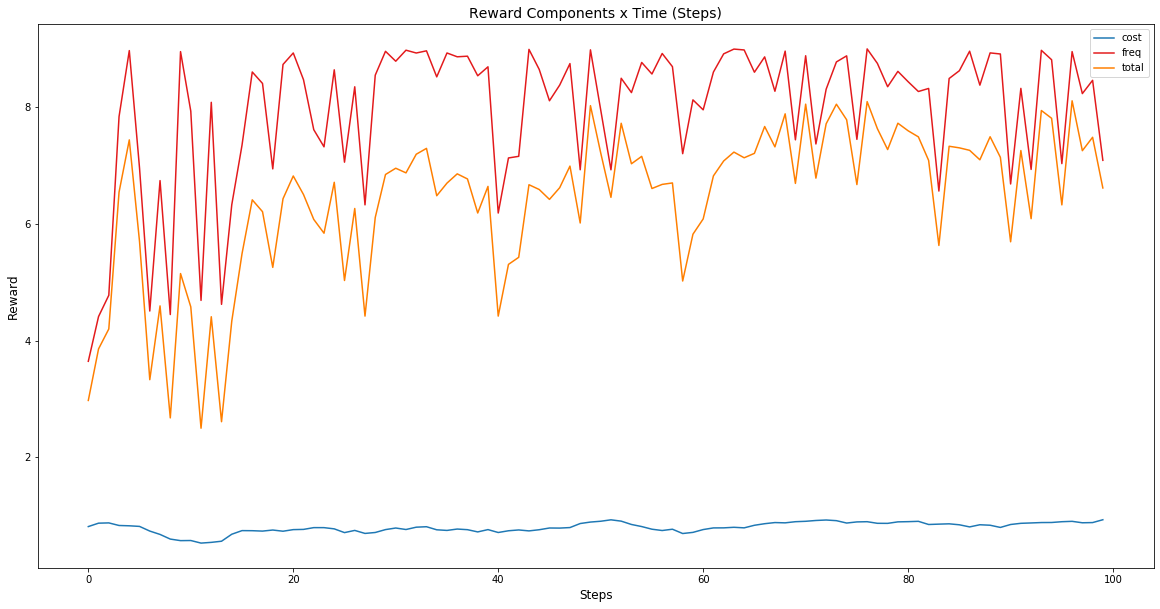

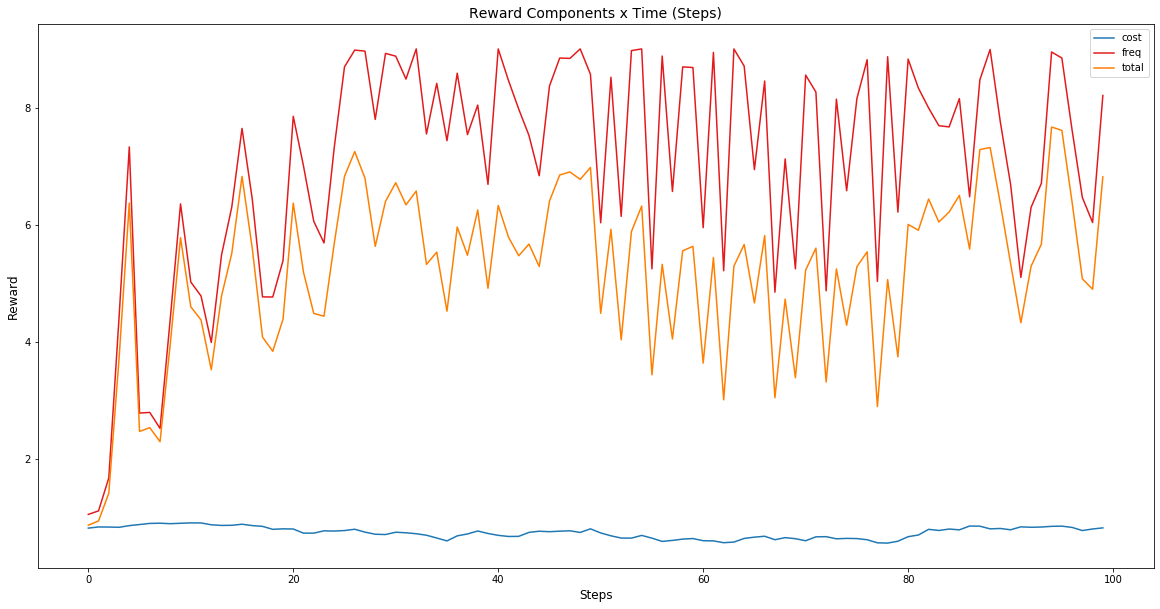

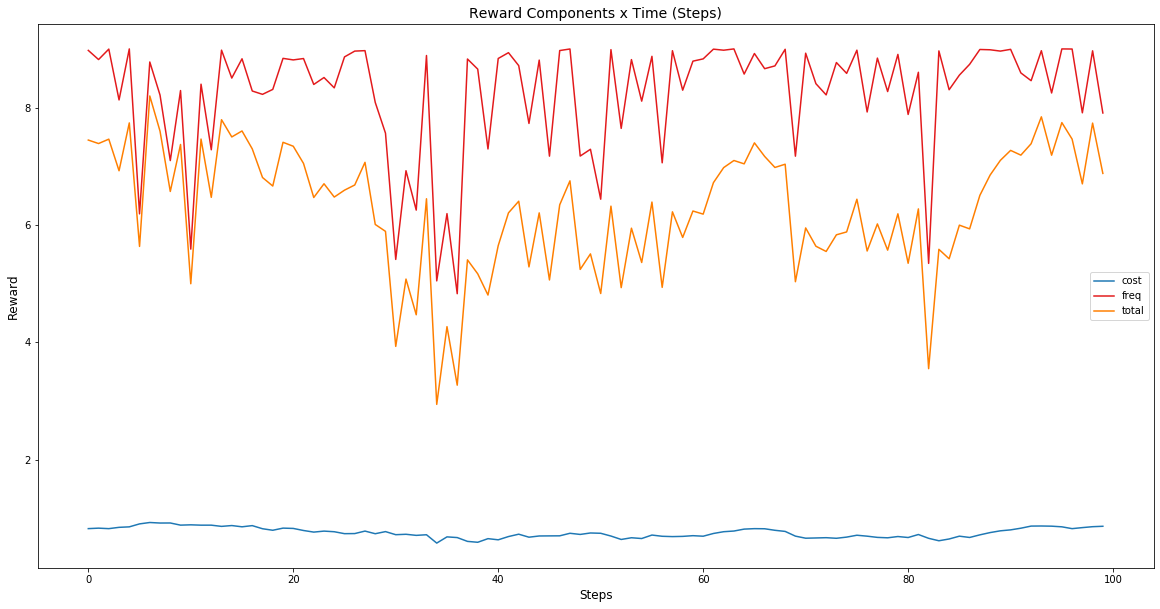

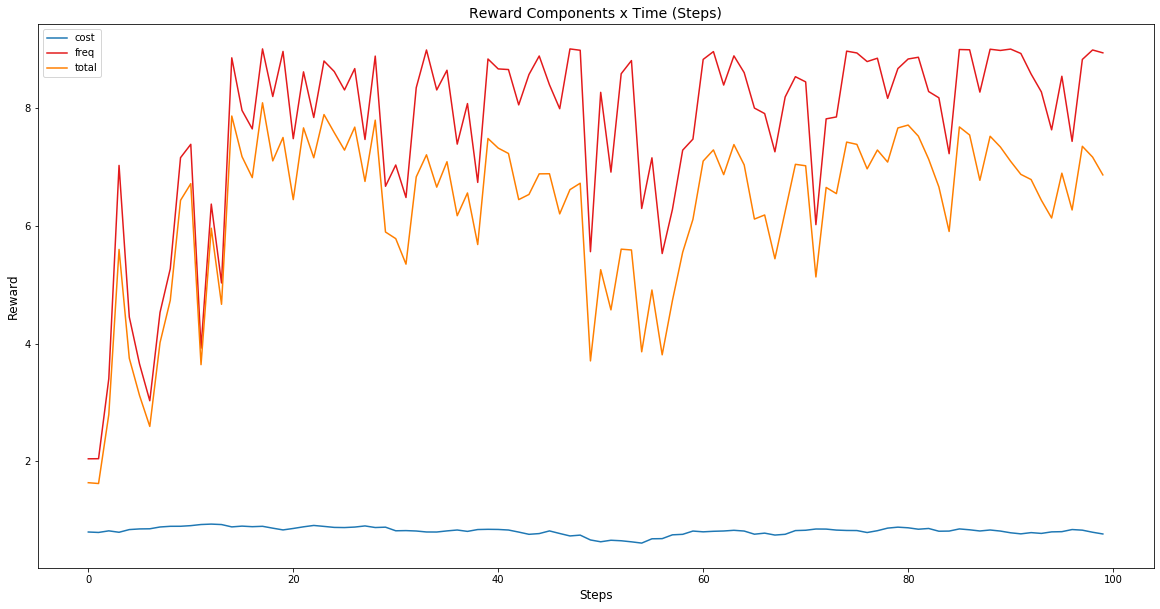

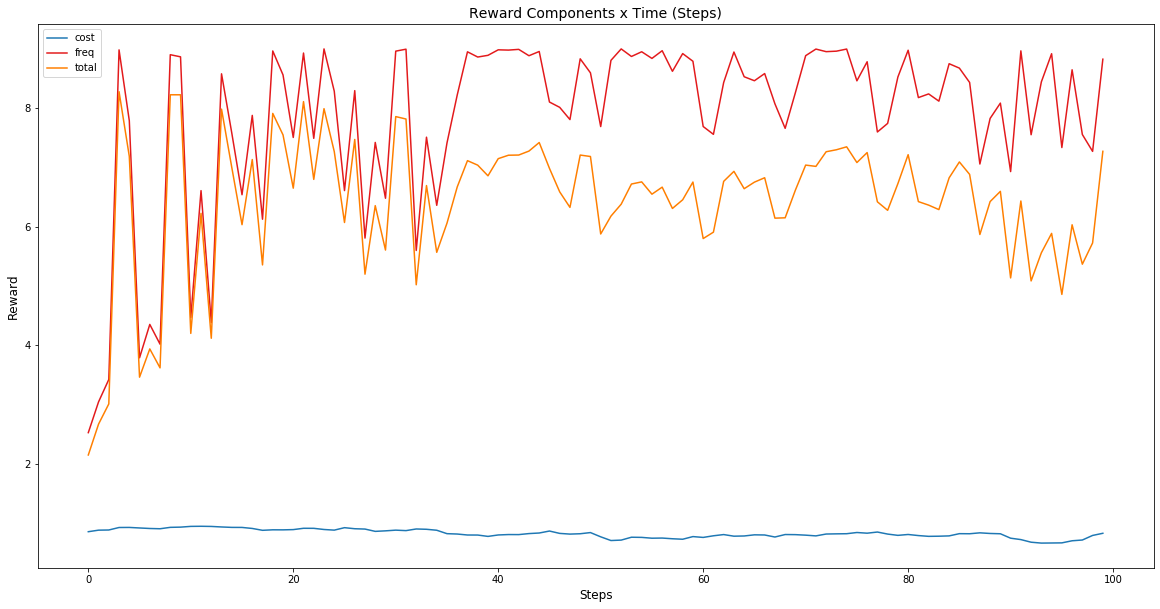

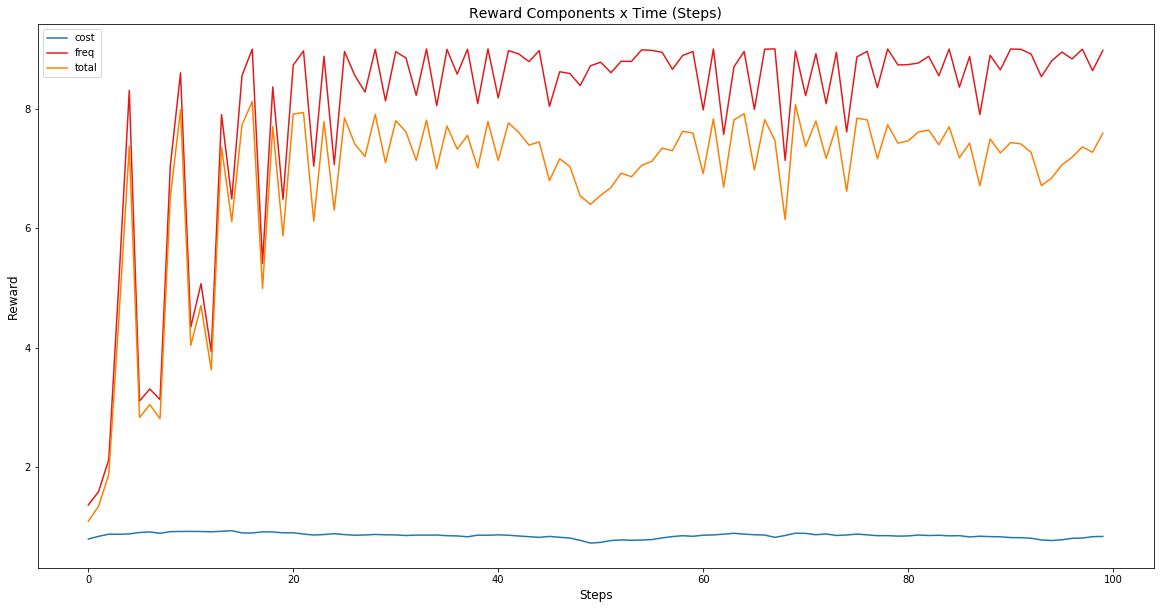

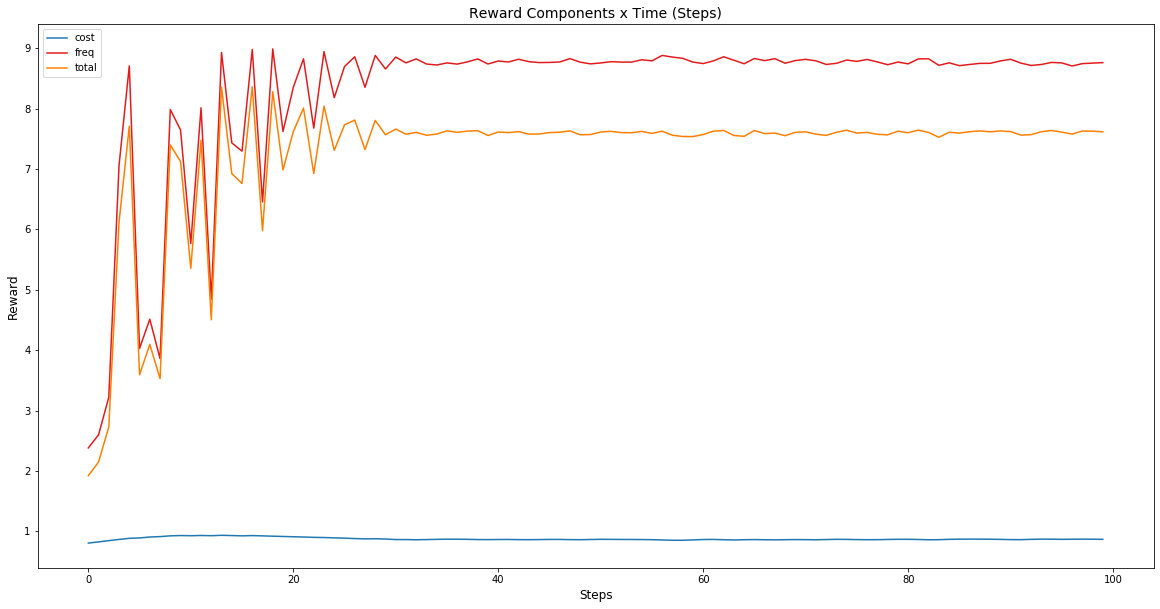

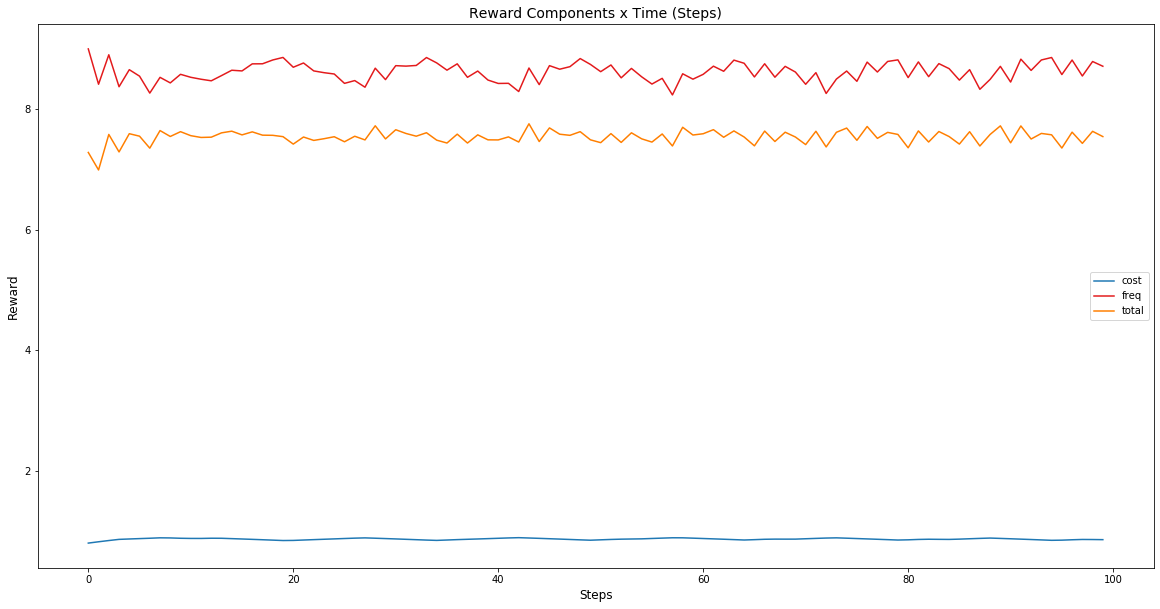

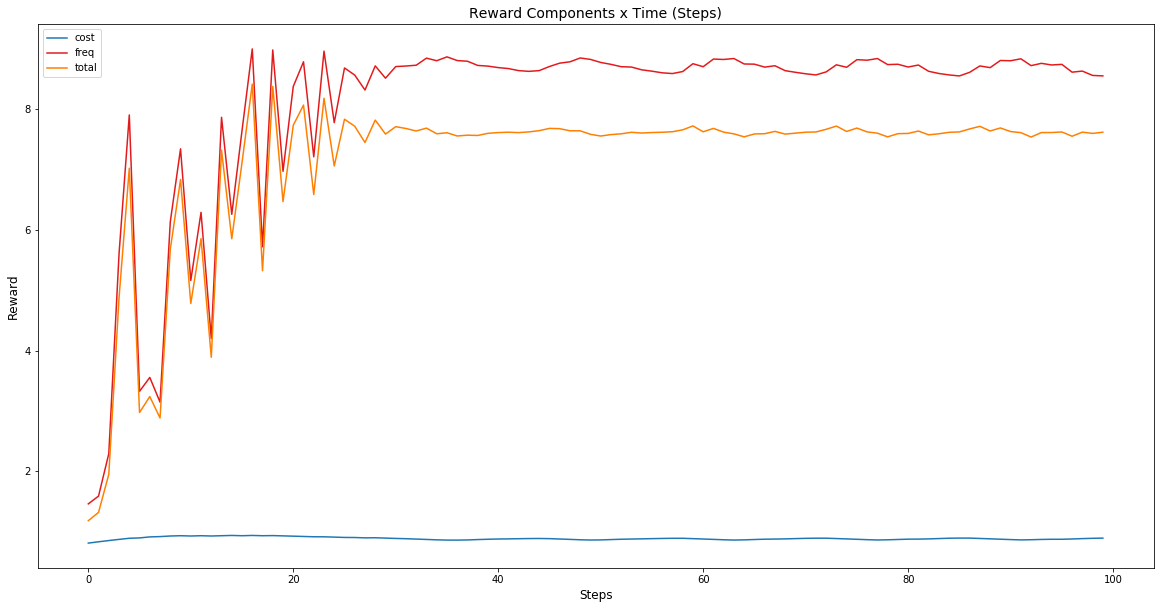

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2208.5601913804594

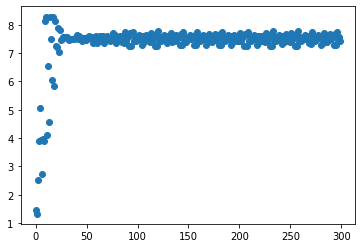

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

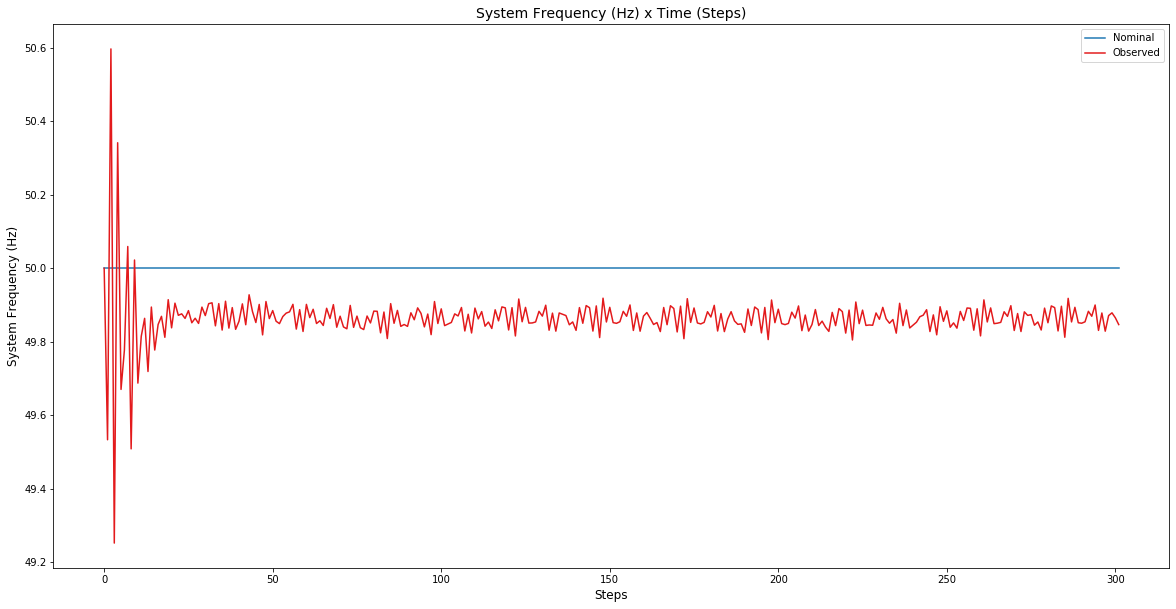

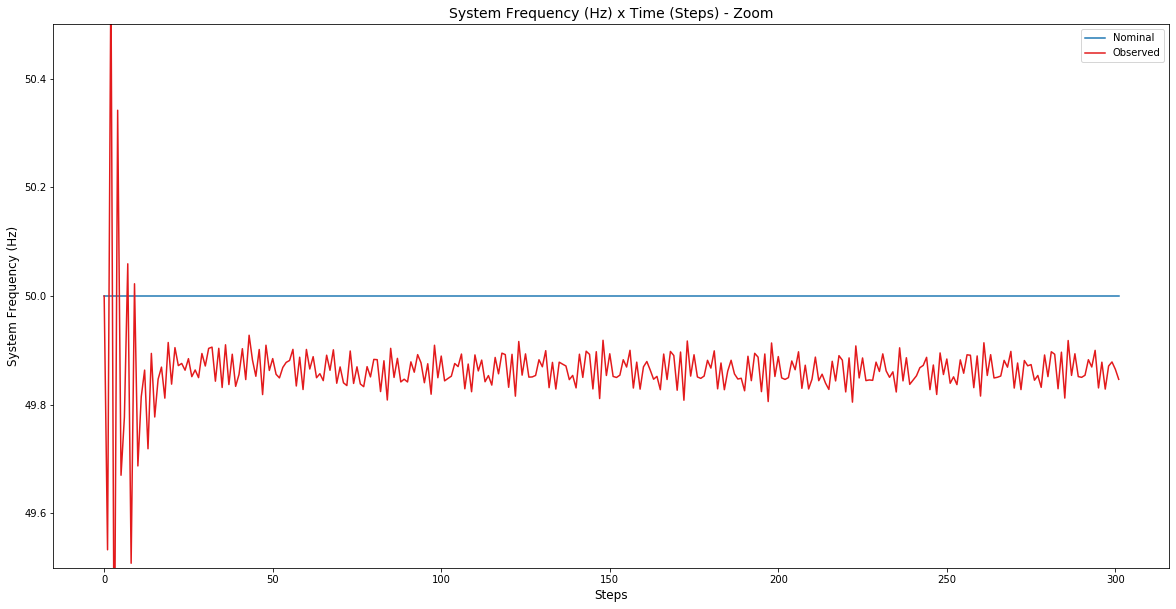

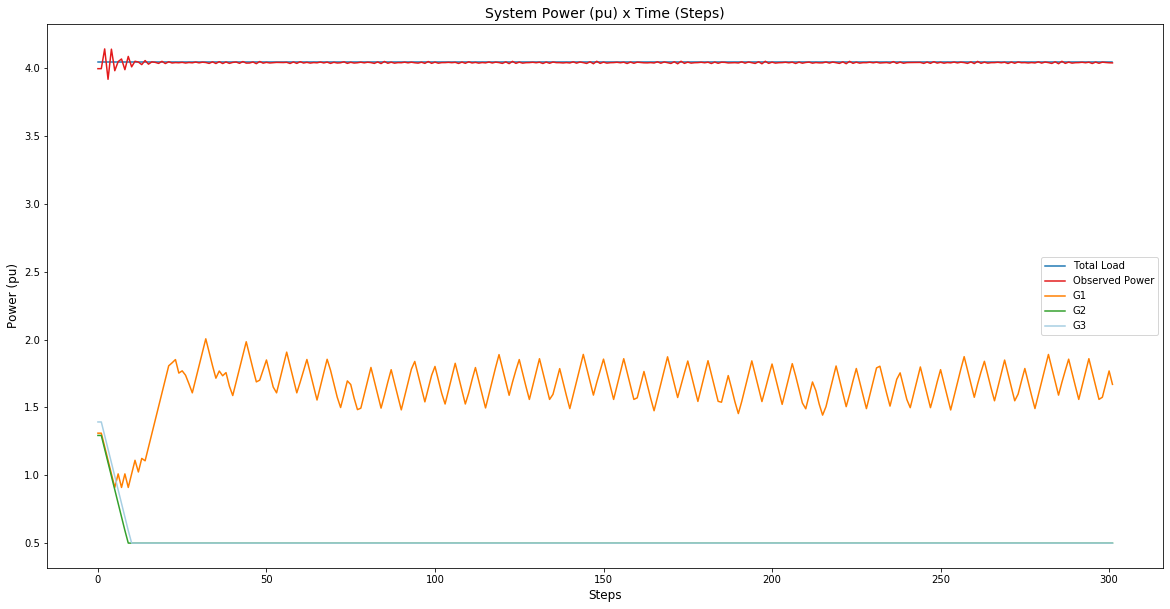

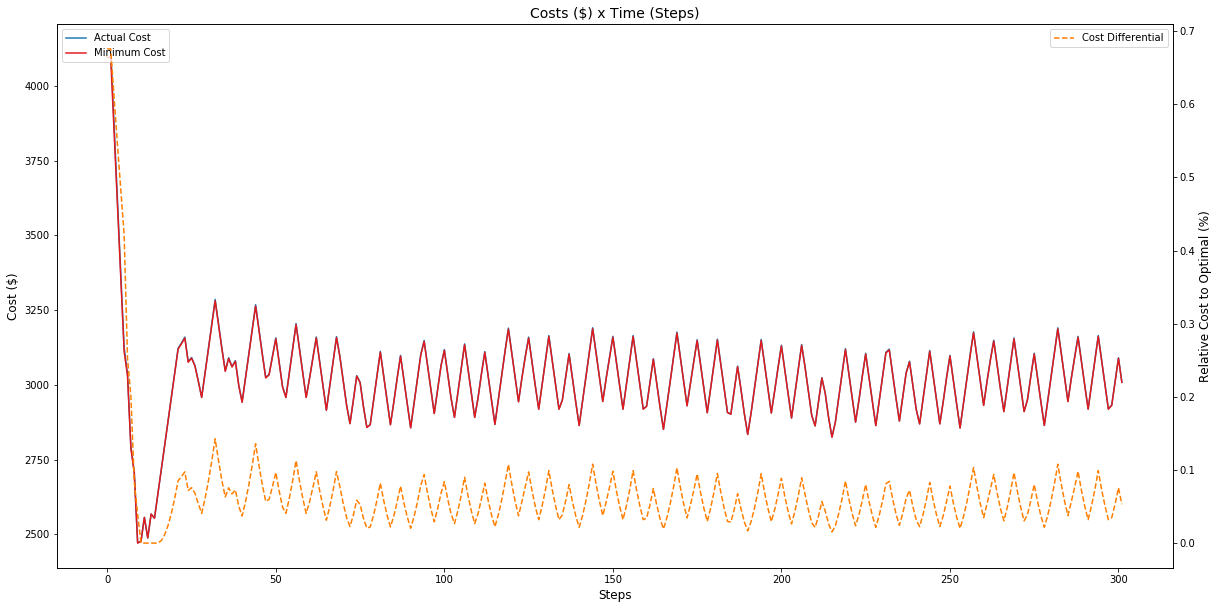

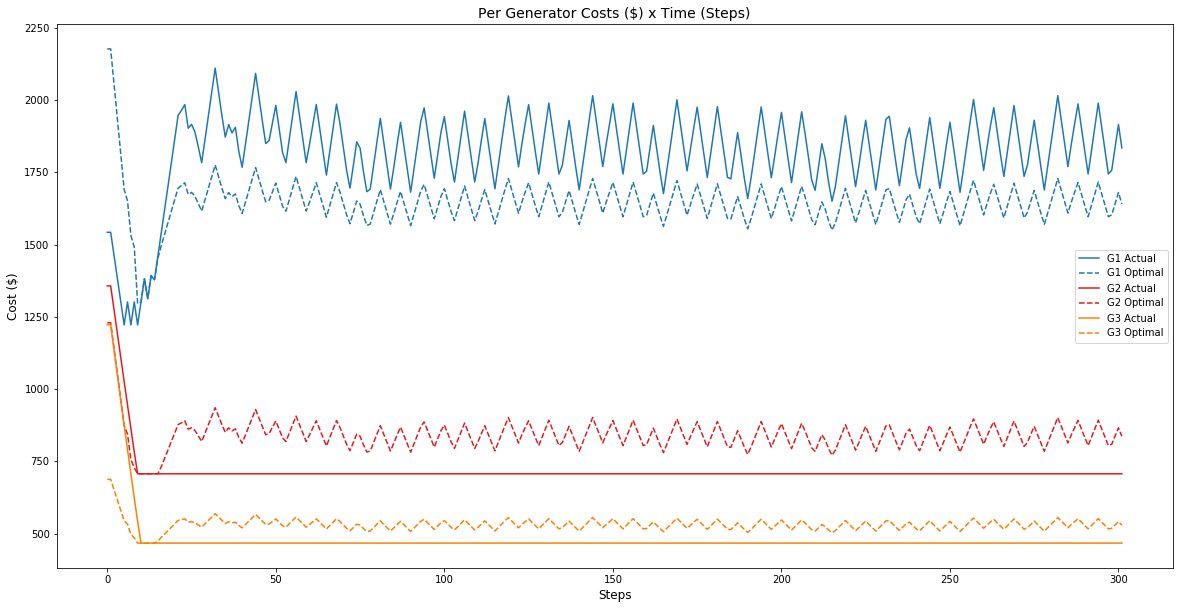

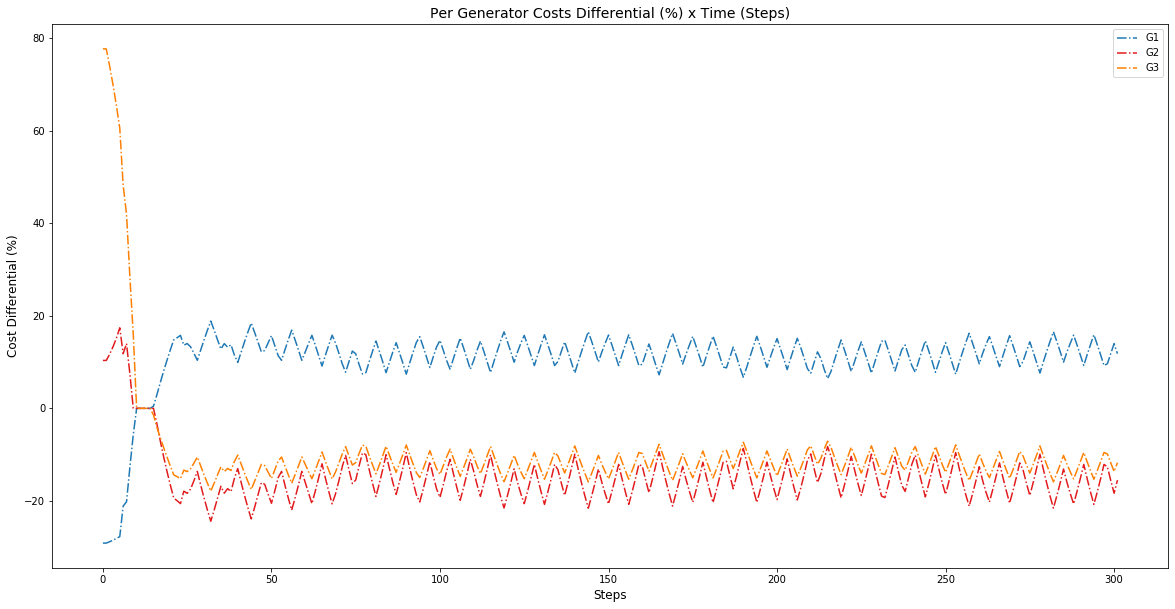

In [21]:
plotAll(electricalSystem.systemHistory)

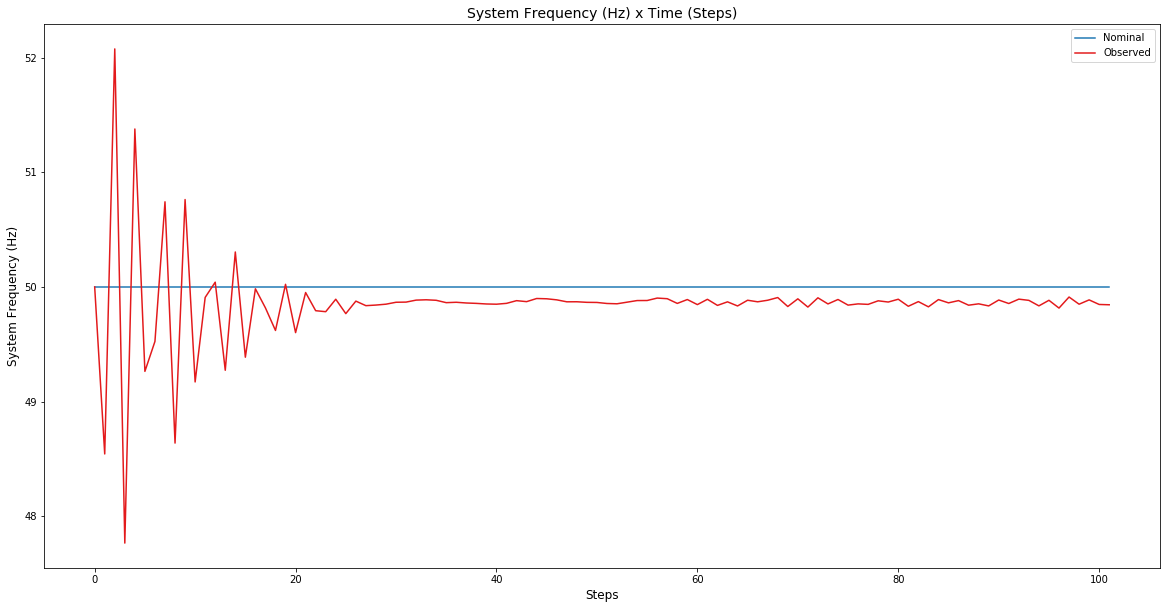

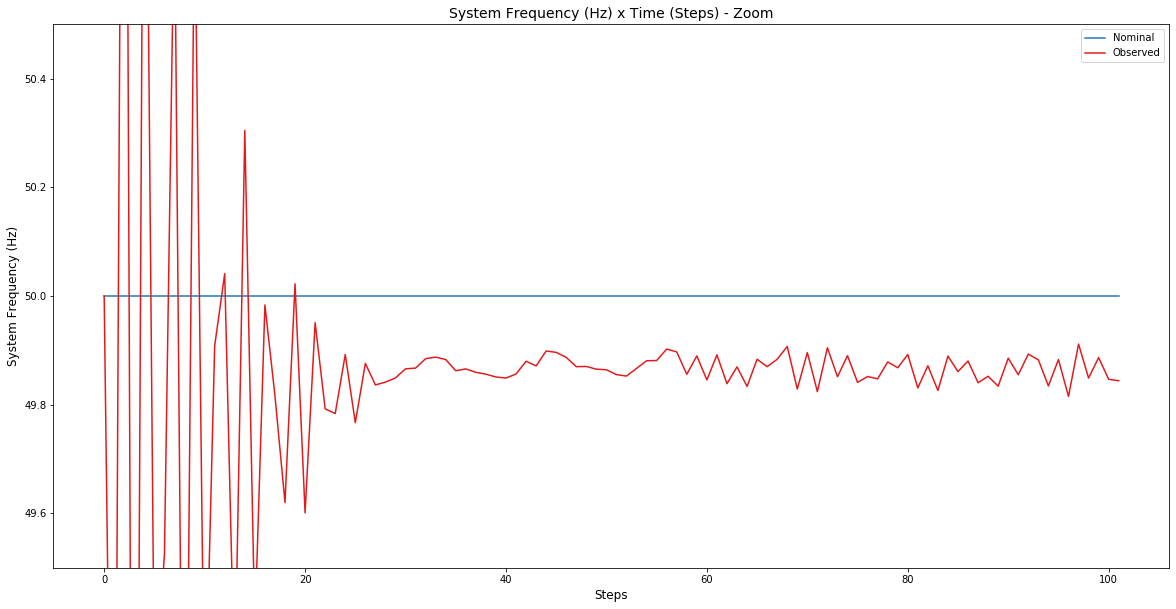

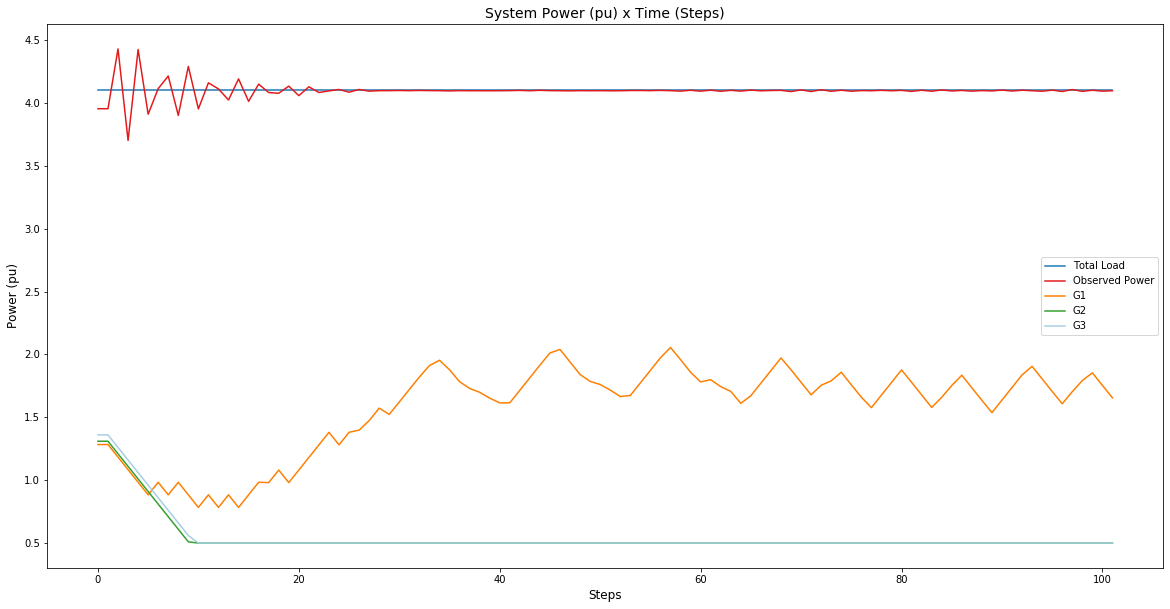

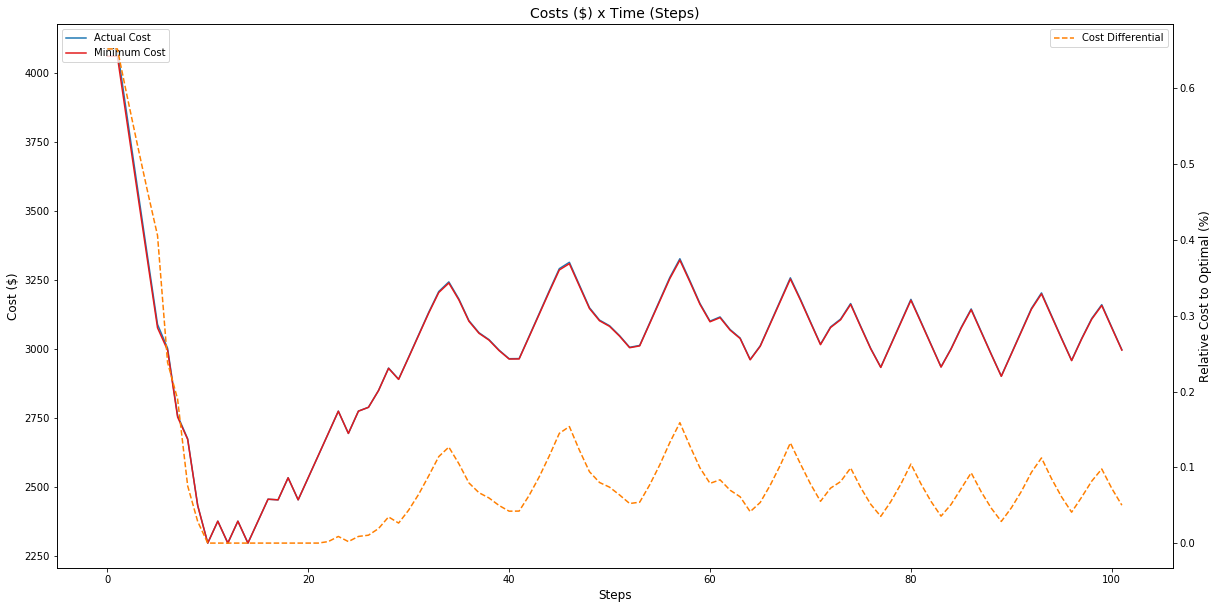

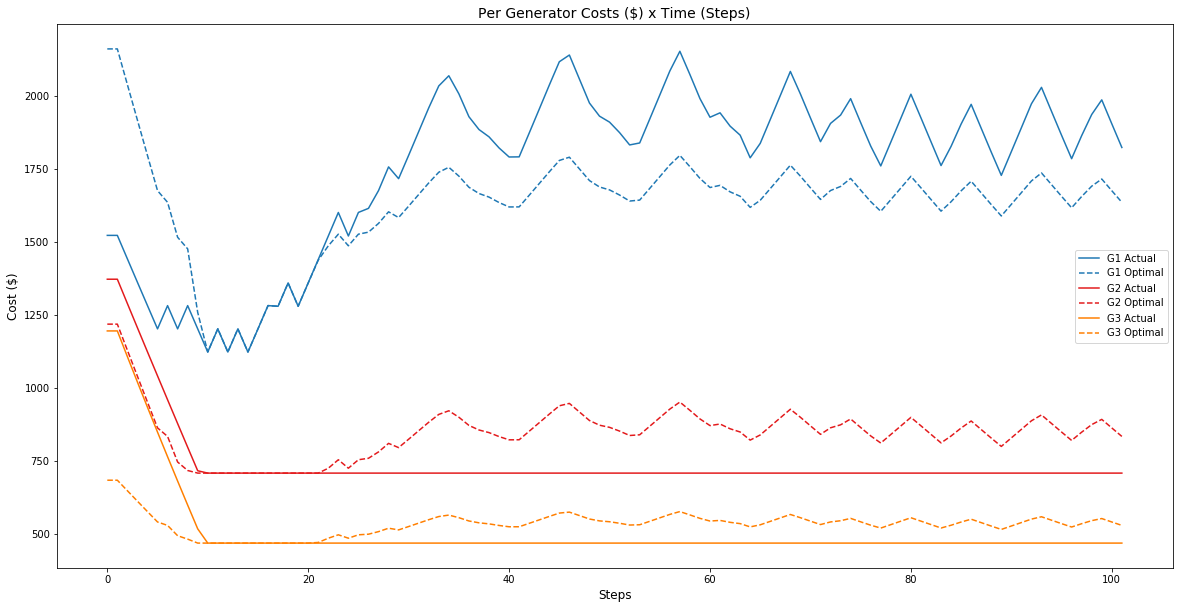

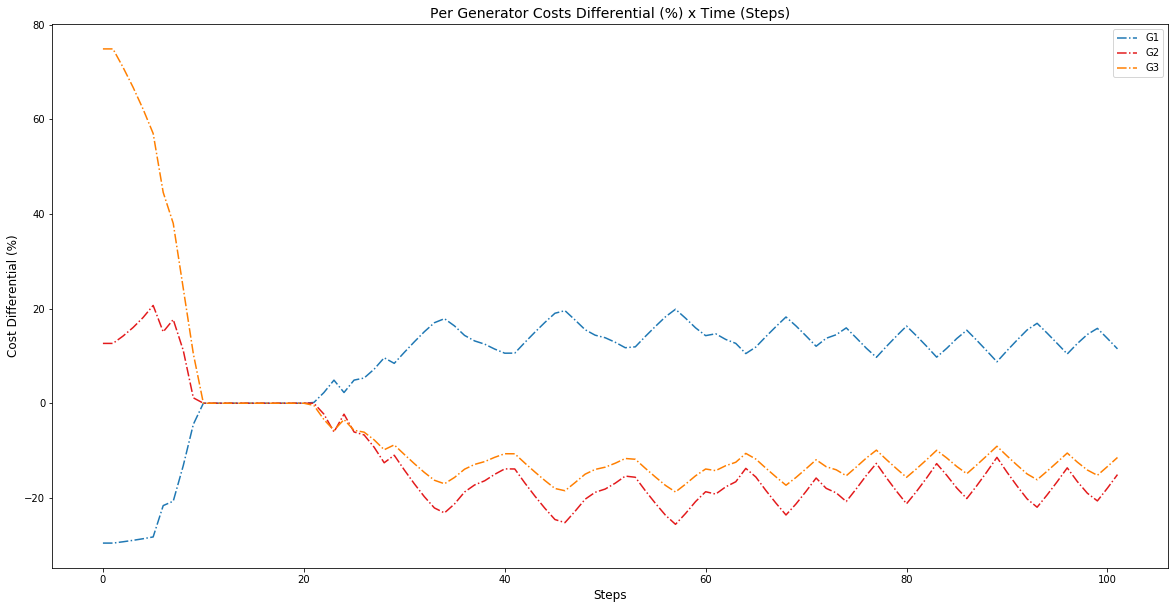

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.8161130584923838,
   'freq': 3.647834212372376,
   'total': 2.977045135932376},
  {'cost': 0.8744748518262513,
   'freq': 4.414365477057295,
   'total': 3.8602515964565973},
  {'cost': 0.8792295324813716,
   'freq': 4.778649291874997,
   'total': 4.201529582787691},
  {'cost': 0.8348607008671727,
   'freq': 7.840300089936051,
   'total': 6.545558428092968},
  {'cost': 0.8294991369921052,
   'freq': 8.97074751431431,
   'total': 7.441227321297792},
  {'cost': 0.8189980048290582,
   'freq': 6.956538349482057,
   'total': 5.697391028742634},
  {'cost': 0.7391296440468771,
   'freq': 4.509031872127098,
   'total': 3.332759122641326},
  {'cost': 0.6817009676862434,
   'freq': 6.743354908200459,
   'total': 4.596951566372032},
  {'cost': 0.6019756431524093,
   'freq': 4.448704979455997,
   'total': 2.6780120412033495},
  {'cost': 0.575317625822912,
   'freq': 8.953381202373466,
   'total': 5.151038016436992},
  {'cost': 0.5773842485189098,
   'freq': 7.933420913928522,
   'total

TypeError: float() argument must be a string or a number, not 'dict'

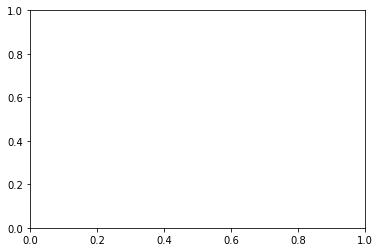

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()